In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense, Conv2D, MaxPooling2D, Reshape, Lambda, Permute
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.backend import clear_session
from tensorflow.keras import regularizers 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from tensorflow.keras.utils import plot_model

def clean_text(tweet):
    #remove emoji
    emoji = re.compile("["
                        u'\U0001F600-\U0001F64F'  
                        u'\U0001F300-\U0001F5FF'  
                        u'\U0001F680-\U0001F6FF'  
                        u'\U0001F1E0-\U0001F1FF'  
                        u'\U00002702-\U000027B0'
                        u'\U000024C2-\U0001F251'
                        "]+", flags=re.UNICODE)
    tweet = emoji.sub(r'', tweet)

    #remove punctuation
    punctuation = '''!\(\)-\[]\{};:'"\,<>./?@#$%^&*_~=+…''' + u'\u060C' + u'\u061B' + u'\u061F'
    for c in tweet:
        if c in punctuation:
            tweet = tweet.replace(c, '')

    #remove laughter
    laughter = re.compile(r'\b(ه|خ)\1{2,}\b')
    tweet = laughter.sub('', tweet)

    #remove nonsense
    nonsense = re.compile(r'\b(.)\1{2,}\b')
    tweet = nonsense.sub(r'', tweet)

    #normalize elongated words
    repeated_characters = re.compile(r'(.)\1{2,}')
    tweet = repeated_characters.sub(r'\1', tweet)

    return tweet

def ArabicToArabizi(tweet):
    arabicLetterList = ['ض','ص','ث','ق' ,'ف' ,
                                  'غ' ,'ع' ,'ه','خ' ,'ح' ,
                                  'ج' ,'د' ,'ش' ,'س' ,'ي' ,
                                  'ن','ت' ,'ا' ,'ل','ب',
                                  'ء','ئ','ط' ,'ك','م',
                                  'ؤ','ر','لا','ى','ة',
                                  'و','ز' ,'ظ','لأ','أ' ,
                             'إ', 'آ', ' ','ذ']
    
    arabiziMappingList = [['d'],['s'],['th'],[ '2'],['f'],
                      ['8'], [ '3'], ['h'], ['5'],['7'],
                      ['j'], ['d'], ['sh'], ['s'], ['y'],
                      ['n'], ['t'], ['a'], ['l'], ['b'],
                      ['2'],['2'], ['t'], ['k'], ['m'],
                      ['o2'], ['r'], ['la'], ['a'], ['a'],
                      ['o'], ['z'], ['z'], ['la2'], ['2'],
                      ['2'],['2'], [' '], ['z']]
    arabiziSentence =''
    arabicToArabiziMapping = dict()
    for x in range(0, len(arabicLetterList)):
        arabicToArabiziMapping[arabicLetterList[x]] = arabiziMappingList[x] 
    for x in range(0, len(tweet)):
        if tweet[x] in arabicToArabiziMapping.keys():
            if tweet[x] ==  'و':
                if x == 0:
                    arabiziSentence = arabiziSentence + 'w'
                elif tweet[x-1] ==' ':
                    arabiziSentence = arabiziSentence + 'w'
                else:
                    arabiziSentence = arabiziSentence + 'o'
            else :
                arabiziSentence = arabiziSentence + arabicToArabiziMapping[tweet[x]][random.randint(0,
                                                                 len(arabicToArabiziMapping[tweet[x]])-1)]
    arabiziSentence = arabiziSentence.replace( 'alozyr', 'alwazer')
    arabiziSentence = arabiziSentence.replace( 'hza', 'hayda')
    arabiziSentence = arabiziSentence.replace( 'hzh', 'hayde')
    arabiziSentence = arabiziSentence.replace( ' lao ', ' law ')
    arabiziSentence = arabiziSentence.replace( ' ho ', ' huwe ')
    arabiziSentence = arabiziSentence.replace( 'jbran ', ' gebran ')
    arabiziSentence = arabiziSentence.replace( 'qtr ', ' qatar ')
    arabiziSentence = arabiziSentence.replace( 'wlyd ', ' walid ')
    arabiziSentence = arabiziSentence.replace( 'al7ryry ', ' al hariri ')
    return arabiziSentence

In [2]:
df = pd.read_csv('SemEval2017-task4-train.subtask-A.arabic.txt',sep="\t",names=['ID','Class','Tweet'])
df

,ID,Class,Tweet
0,783555835494592513,positive,إجبار أبل على التعاون على فك شفرة اجهزتها http...
1,783582397166125056,positive,RT @20fourMedia: #غوغل تتحدى أبل وأمازون بأجهز...
2,783592390728769536,positive,جوجل تنافس أبل وسامسونج بهاتف جديد https://t.c...
3,783597390070685696,positive,رئيس شركة أبل: الواقع المعزز سيصبح أهم من الطع...
4,783617442031472640,neutral,ساعة أبل في الأسواق مرة أخرى https://t.co/dY2x...
...,...,...,...
3348,785923681432117248,positive,طريقة تعطيل اي زر في لوحة المفاتيح على نظام وي...
3349,785924823860076544,neutral,RT @syst__em: إطلاق تحديث تراكمي برقم 14393.32...
3350,785929366756655104,neutral,4 طرق لحذف الملفات المستعصية من الحذف في ويندو...
3351,785951682467246080,neutral,شرح فيديو مهم جدا حل لمشاكل الكومبيوتر كيف تقو...


In [3]:
data = df[['Class','Tweet']].copy()

# Data Preprocessing

In [4]:
newArabiziDataset = dict()
arabiziTweets = []
arabiziClasses = []
count = 0
for tweet in data['Tweet']:
    newTweet = ArabicToArabizi(clean_text(tweet))
    arabiziTweets.append(newTweet)
    arabiziClasses.append(data['Class'][count])
    count = count + 1

newArabiziDataset['Tweet'] = arabiziTweets
newArabiziDataset['Class'] = arabiziClasses
data = pd.DataFrame(newArabiziDataset, columns= ['Tweet', 'Class'])

In [5]:
data

,Tweet,Class
0,2jbar 2bl 3la alt3aon 3la fk shfra ajhztha,positive
1,8o8l tt7da 2bl w2mazon b2jhayda jdyda,positive
2,jojl tnafs 2bl wsamsonj bhatf jdyd,positive
3,r2ys shrka 2bl aloa23 alm3zz sysb7 2hm mn alt3am,positive
4,sa3a 2bl fy al2soa2 mra 25ra,neutral
...,...,...
3348,try2a t3tyl ay zr fy lo7a almfaty7 3la nzam wy...,positive
3349,2tla2 t7dyth trakmy br2m l wyndoz almktby ...,neutral
3350,tr2 l7zf almlfat almst3sya mn al7zf fy wyndoz...,neutral
3351,shr7 fydyo mhm jda 7l lmshakl alkombyotr kyf t...,neutral


In [6]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 280

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(data['Tweet'].values)
VOCAB_SIZE = len(tokenizer.word_index) + 1
word_list = list(tokenizer.word_index.keys())

X = tokenizer.texts_to_sequences(data['Tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

y = pd.get_dummies(data['Class'].values)
label_names = y.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2682, 280) (2682, 3)
(671, 280) (671, 3)


# CNN-LSTM Model

In [7]:
#Tuned
dropout_rate = 0.1
lstm_dropout = 0.7
lstm_units = 20
nb_filters = 64
filter_size = 3
L1=0.263
L2=0.15

#Not Tunable
EMBEDDING_DIM = 100
clear_session()
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Permute((2,1), input_shape = (MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)))
model.add(Lambda(lambda t: t[..., None]))
model.add(Conv2D(nb_filters, (100,filter_size), input_shape=(EMBEDDING_DIM, MAX_SEQUENCE_LENGTH, 1), name = 'Conv'))
model.add(MaxPooling2D(pool_size= model.get_layer('Conv').output_shape[1:3]))
model.add(Dropout(dropout_rate))
model.add(Reshape((1, nb_filters)))
model.add(LSTM(lstm_units, return_sequences=False))
model.add(Dropout(lstm_dropout))
model.add(Dense(3, activation='softmax', kernel_regularizer = regularizers.l1_l2(l1= L1, l2= L2)))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 280, 100)          1582900   
_________________________________________________________________
permute (Permute)            (None, 100, 280)          0         
_________________________________________________________________
lambda (Lambda)              (None, 100, 280, 1)       0         
_________________________________________________________________
Conv (Conv2D)                (None, 1, 278, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 64)          0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 64)             0

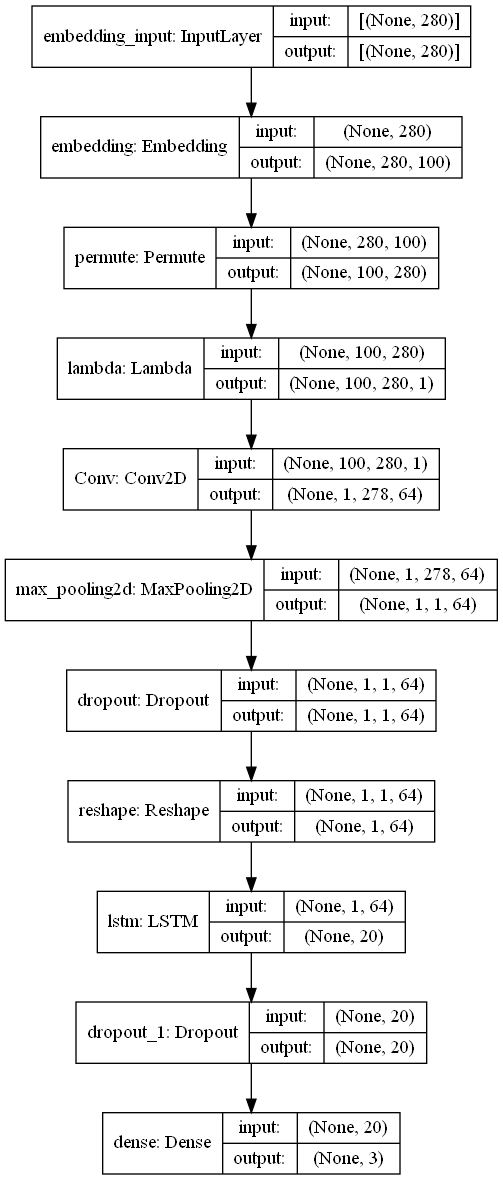

In [11]:
plot_model(model, to_file = 'CNN-LSTM.png', show_shapes = True, show_layer_names = True)

In [9]:
e = 50
batch_size = 256
history = model.fit(X_train, y_train, validation_split=0.2, verbose=1, epochs = e, batch_size = batch_size)

Epoch 1/50
9/9 [==============================] - 14s 297ms/step - loss: 6.1283 - accuracy: 0.4126 - val_loss: 6.0149 - val_accuracy: 0.4320
Epoch 2/50
9/9 [==============================] - 0s 32ms/step - loss: 5.9397 - accuracy: 0.4368 - val_loss: 5.8276 - val_accuracy: 0.4320
Epoch 3/50
9/9 [==============================] - 0s 31ms/step - loss: 5.7541 - accuracy: 0.4331 - val_loss: 5.6461 - val_accuracy: 0.4320
Epoch 4/50
9/9 [==============================] - 0s 31ms/step - loss: 5.5797 - accuracy: 0.4308 - val_loss: 5.4747 - val_accuracy: 0.4320
Epoch 5/50
9/9 [==============================] - 0s 30ms/step - loss: 5.4052 - accuracy: 0.4410 - val_loss: 5.3086 - val_accuracy: 0.4320
Epoch 6/50
9/9 [==============================] - 0s 31ms/step - loss: 5.2390 - accuracy: 0.4634 - val_loss: 5.1459 - val_accuracy: 0.4320
Epoch 7/50
9/9 [==============================] - 0s 31ms/step - loss: 5.0477 - accuracy: 0.5166 - val_loss: 4.9754 - val_accuracy: 0.4544
Epoch 8/50
9/9 [=========